# Least-squares regression as a DL problem

In this tutorial, we implement some of the key takeaways from the statistical learning theory lecture by Prof. Frank Noé. This is the [second part](https://www.youtube.com/watch?v=-3RV_aUCT8w&list=PLqPI2gxxYgMKN5AVcTajQ79BTV4BiFN_0&index=7) (following the introduction) of his deep learning YouTube playlist.

We will need the following Julia packages in this tutorial:

In [1]:
using Base.Iterators, Random, Statistics
using Plots, ChainPlots, LaTeXStrings, ProgressMeter

To highlight our use of Julia's "standard" deep learning package `Flux`, please take a few moments to gloss over the functions we will be utilizing:

In [2]:
using Flux
using Flux: params, early_stopping
using Flux.Losses: mse
using Flux.Data: DataLoader
using Flux.Optimise: train!

In this notebook, we will elect *NOT* to use the CUDA API (through the `CUDA` package) to pass certain routines to the (NVidia) GPU, as the networks are neither wide nor deep enough to take advantage of this kind of parellelization. We will, however, put all the necessary `|> gpu` and `|> cpu` pipes put in where necessary. The following code block is good practice to include for any DL problem using `Flux`:

In [3]:
using CUDA
use_cuda = false    # GPU will be too slow here
if CUDA.functional() && use_cuda
    @info "Training on CUDA GPU"
    CUDA.allowscalar(false)
    device = gpu
else
    @info "Training on CPU"
    device = cpu
end

┌ Info: Training on CPU
└ @ Main In[3]:8


cpu (generic function with 1 method)

## Background

To make things concrete from the start, let's imagine that we want to fit some 1D input ($x$) and 1D output ($y$) data $\mathcal{D} = \{(x_j,y_j)\}_{j=1}^n$ to a nonlinear function $f$ such that

$$
\hat y := f(x),
$$

and we minimize the "averaged error" between $\hat y$ and $y$ across $\mathcal{D}$. This *sounds* simple enough, but it should be a daunting task! For instance, ask yourself how many different $f$'s you should check before you are satisfied. To make this a more tractable problem, let's say that we can decompose $f$ into a (possibly infinite) sum of "basis functions" $\{\varphi_i\}_{i=1}^\infty$:

$$
f(x) = \sum_{i=1}^\infty c_i\varphi_i(x).
$$

If we know this basis, fitting the nonlinear function turns into merely fitting the coefficients $\{c_i\}_{i=1}^\infty$. This is a *linear* problem! 

For instance, we might make the assumption that our target function belongs to the **hypothesis set** of polynomials, i.e., $f\in\mathcal{H}=\mathcal{P}$. If we trucate the series at some sufficiently large $p\in\mathbb{N}$, we get an approximation

$$
f(x) \approx \sum_{i=0}^p c_i\varphi_i(x) \in \mathcal{P}_p,
$$

where the basis functions $\{\varphi_i\}_{i=0}^p$ are, e.g., the set of monomials up to degree $p$ (you could also pick Chebychev or Legendre polynomials, for instance).

While this is a very simple linear regression problem, we will formulate this as a **deep learning (DL)** problem and solve it accordingly (knowing full well that this is computationally impractical) solely to set up a "recipe" for more complicated DL problems.

### Shallow linear neural network

A DL solution hinges on the *depth* of the **neural network (NN)** connecting the input and output layers, as well as the *nonlinearity* of the activation functions on its hidden layers (we will delay the discussion of these concepts until later tutorials). However, the NNs we will construct here are both *shallow* and *linear*.

For instance, if we assume that our function $f$ is an *affine* function

$$
\hat y = f(x) := w_1x + b,
$$

we could represent this as a NN with one input, one output, and two parameters, $w_1$ and $b$. Let's visualize this simple NN (using this wonderful [`ChainPlots`](https://github.com/rmsrosa/ChainPlots.jl) package, which you can add to your Julia environment with `Pkg.add(url="https://github.com/rmsrosa/ChainPlots.jl.git")` or `]add https://github.com/rmsrosa/ChainPlots.jl.git` in the REPL):

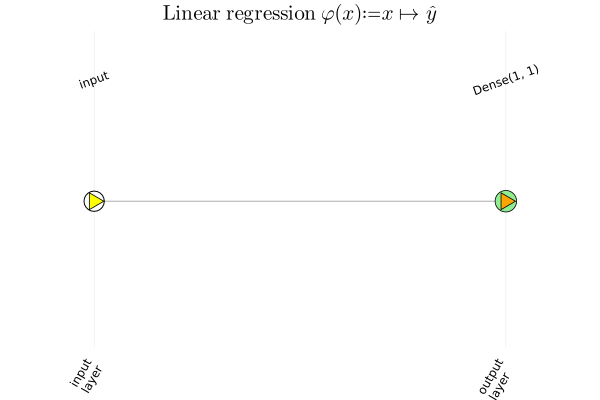

In [4]:
𝒩 = Chain(Dense(1,1))
fig = plot(𝒩,title=L"\textrm{Linear\ regression}\ \varphi(x)\coloneq x\mapsto\hat y")

If we know the above parameters, we could feed the an input $x$ into the NN and we will get an estimate for the output: $\hat y = \mathcal{N}(x;\theta)$, where $\theta$ is the set of parameters. This is a "forward problem", but we are usually interested in the "inverse problem" of figuring out $\theta$ given the data $\mathcal{D}$.

What if we had instead assumed that $f$ was a polynomial of degree 4? Then we would have

$$
\hat y = f(x) := w_4\underbrace{x^4}_{\varphi_4(x)} + w_3\underbrace{x^3}_{\varphi_3(x)} + w_2\underbrace{x^2}_{\varphi_2(x)} + w_1\underbrace{x}_{\varphi_1(x)} + b = \mathbf{w}^T\mathbf{\varphi}(x) + b,
$$

where the parameters $\theta$ are now the *vector* $\mathbf{w}:=[w_1\ \ w_2\ \ w_3\ \ w_4]^T$ and scalar $b$, and the input is the *feature* vector $\mathbf{\varphi}(x):=[\varphi_1(x)\ \ \varphi_2(x)\ \ \varphi_3(x)\ \ \varphi_4(x)]^T$. Similar to before, we would like to find $\theta$ such that when we feed the input data forward through the NN, our estimate $\hat y = \mathcal{N}(\mathbf{\varphi}(x),\theta)$ matches the output data $y$. A visualization of this NN is:

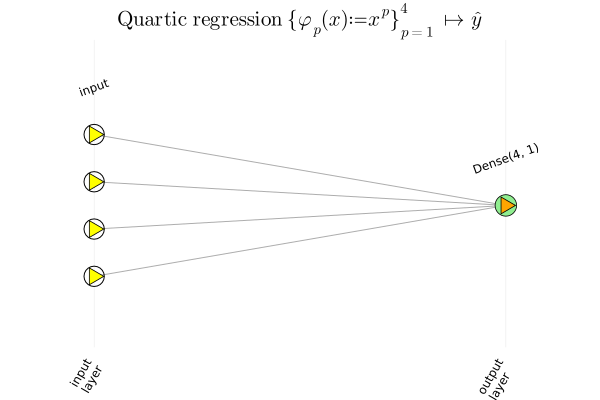

In [5]:
𝒩 = Chain(Dense(4,1))
fig = plot(𝒩,title=L"\textrm{Quartic\ regression}\ \{\varphi_p(x)\coloneq x^p\}_{p=1}^4\mapsto\hat y")

Note that in both network plots, the constant "bias" $b$ is not explicitly displayed. We could extend this to higher-degree polynomials by choosing an appropriate $p$, as well as to other, non-polynomial functions as sums of arbitrary basis functions.

## Data generation

For the purpose of this tutorial, we will consider a third-degree polynomial function $f\in\mathcal{P}_3$ as the true, data-generating function. Since we will be using the *monomial* basis functions $\varphi_p$ quite often, let's define Julia functions that computes the $p$-th degree monomial value and the polynomial value given a parameter set $\theta=\{\mathbf{w},b\}$.

In [6]:
ϕ(x,p) = x^p
𝒫(x,θ) = (θ[1]*ϕ.(x,1:length(θ[1])) + θ[2])[1]

𝒫 (generic function with 1 method)

We will define the data generating parameter set as $\bar\theta = \{[0\ \ -4\ \ 3.5]^T,0.5\}$, which generates the unobserved noiseless data $\{\bar y_j := f(x_j;\bar\theta)\}_{j=1}^{N=50}$ from the 1D inputs $\{x_j\}_{j=1}^N$. The observed data will be generated by adding some $\{\xi_j \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0,1)\}_{j=1}^N$ noise to get the 1D outputs $\{y_j := \bar y_j + \xi_j\}_{j=1}^N$. We visualize the data below, along with the data-generating model $f$:

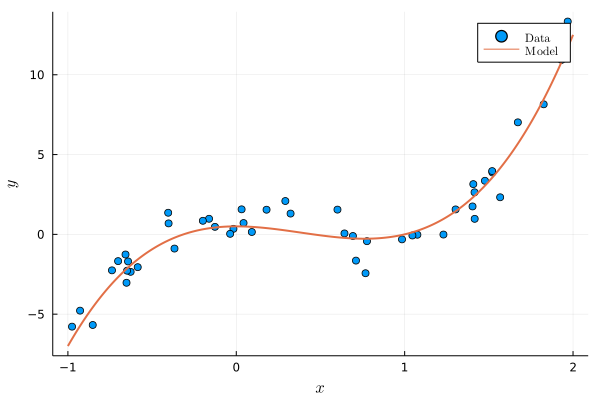

In [7]:
Random.seed!(1)
N = 50
x0,xf = -1,2
x = (xf-x0)*rand(N) .+ x0    # 1D inputs
c0,c1,c2,c3 = 0.5, 0, -4, 3.5    # polynomial coefficients
θ̄ = [[c1 c2 c3],[c0]]    # "true" weights and bias
ȳ = c3*x.^3 .+ c2*x.^2 .+ c1*x .+ c0    # data-generating model
ξ = 1*randn(N)    # noise
y = ȳ .+ ξ    # 1D outputs

X = range(x0,xf,length=500)
fig = plot(xlabel=L"x",ylabel=L"y")
fig = scatter!(x,y,label=L"\mathrm{Data}")
fig = plot!(X,𝒫.(X,Ref(θ̄)),width=2,label=L"\mathrm{Model}")

Our objective is to find an estimate of the data-generating function $\hat f$. To do this, we will make an assumption that $\hat f\in\mathcal{P}$ (with an unknown degree) and find an estimate of the parameter set $\hat\theta$ that defines $\hat f$.

### Train/test split

As Prof. Noé mentions in the lectures, we will need a way to assess the accuracy of our estimate (whatever we decide on). Therefore, we split the $N$-sample dataset into **training** and **testing** sets of sizes $n$ and $N-n$, respectively, by random assignment. To stress the point that the test set should be kept uncorrupted until the very end, we will consider the training set (the blue points in the figure below) the "data" $\mathcal{D} = \{x_j,y_j\}_{j=1}^n$ and forget that the test set (the orange points below) even exists.

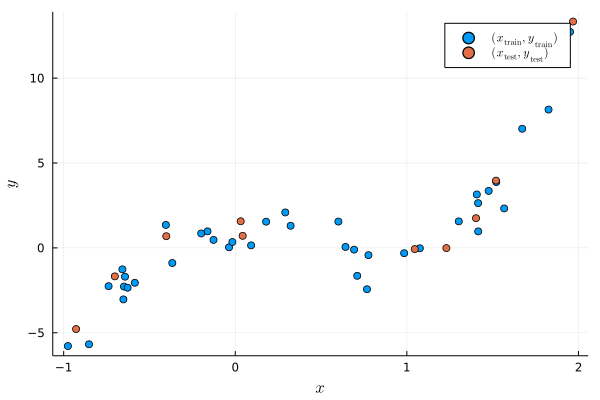

In [8]:
Random.seed!(2)
ℐ = randperm(N)
n = N - N÷5    # keep ~4/5 for training
ℐ,ℐ_test = ℐ[1:n],ℐ[n+1:end]
x,x_test = x[ℐ],x[ℐ_test]
y,y_test = y[ℐ],y[ℐ_test]

fig = plot(xlabel=L"x",ylabel=L"y")
fig = scatter!(x,y,label=L"(x_\mathrm{train},y_\mathrm{train})")
fig = scatter!(x_test,y_test,label=L"(x_\mathrm{test},y_\mathrm{test})")

## Define loss and optimizer

In order to train and assess our model $\hat f$, we need a **loss function** that tells us how badly behaved it is with respect to the data. The loss function depends on the individual problem, but for regression problems, a common loss is the **mean squared error (MSE)**

$$
\mathcal{L}[\hat f(\,\cdot\,;\theta);\mathcal{D}] = \text{MSE}(\hat f(\mathbf{x};\theta),\mathbf{y}) := \frac{1}{n}\sum_{j=1}^n \left(\hat f(x_j;\theta)-y_j\right)^2.
$$

In [9]:
ℒ(f,x,y) = mse(f(x),y)

ℒ (generic function with 1 method)

We'll also need an **optimizer** to perform gradient descent along the loss function and set a maximum number of gradient descent steps (called **epochs**) to be taken to train the model.

In [10]:
η = 0.05
𝒪 = NADAM(η)
M = 10_000    # max number of epochs
ϵ,δ = eps(),100    # early stopping threshold and delay

(2.220446049250313e-16, 100)

## Create cross-validation folds

This problem has a **hyperparameter** that cannot be optimized during training: the *degree* of the polynomial. For that reason, we need an outer loop through various $p$-degree polynomials and evaluate the training for each $p$.

If we had lots and lots of data, we could divide the data again into a training and **validation** set, and evaluate the trained model on the validation data to make the determination on which $p$ to use. However, with small datasets, a one-time training-validation split runs the risk of the evaluation not being generalizable to a more representative dataset.

For that reason, we learned about **cross-validation (CV)**, where we divide the dataset into $K$ **folds** and use the $k$-th fold as the validation set for each CV of the $K$ training iterations:

In [11]:
Random.seed!(3)
K = 5
ℐ = collect(Iterators.partition(randperm(n),n÷K))

5-element Vector{SubArray{Int64, 1, Vector{Int64}, Tuple{UnitRange{Int64}}, true}}:
 [33, 21, 3, 15, 34, 22, 1, 36]
 [7, 14, 27, 8, 18, 31, 32, 4]
 [10, 9, 40, 19, 26, 28, 23, 12]
 [39, 6, 35, 29, 17, 38, 2, 37]
 [20, 5, 30, 13, 25, 16, 24, 11]

Finally, let's decide to consider the hypothesis set to be the set of polynomials up to degree 10: $\mathcal{H} = \mathcal{P}_{10}$.

In [12]:
P = 10    # max polynomial degree

10

## Train and validate

Now that we have our models, data, and optimization method defined, let's run through the training loop:

- **Inputs**: Maximum degree `P`, train data (`x`, `y`, `n`), test data (`x_test`, `y_test`), and CV partition (`ℐ`, `K`)
1. **For** $p\in\{1,\dots,P\}$:
    1. Compute feature matrices $\Phi_p$, $\Phi_p^\text{test}$
    2. **For** $k\in\{1,\dots,K\}$:
        1. Split data into training $\{\Phi_p^\text{train},\mathbf{y}^\text{train}\}$ and validation $\{\Phi_p^\text{val},\mathbf{y}^\text{val}\}$ data
        2. Initialize $\hat f := \mathcal{N}_{\theta_0}$
        3. **For** $m\in\{1,\dots,M\}$:
            1. Run gradient descent to update $\hat f$ with $\hat\theta_p^{(k)}:=\theta_m$ if $\mathcal{L}$ decreases
            2. Break **if** $\mathcal{L}\left[\mathcal{N}_{\theta_m};\{\Phi_p^\text{train},\mathbf{y}^\text{train}\}\right] - \mathcal{L}\left[\mathcal{N}_{\theta_{m-1}};\{\Phi_p^\text{train},\mathbf{y}^\text{train}\}\right] < \epsilon$ for $\delta$ steps
        4. Compute validation MSE $\mathcal{L}\left[\mathcal{N}_{\hat\theta_p^{(k)}};\{\Phi_p^\text{val},\mathbf{y}^\text{val}\}\right]$
    3. Initialize $\hat f := \mathcal{N}_{\theta_0}$
    4. **For** $m\in\{1,\dots,M\}$:
        1. Run gradient descent to update $\hat f$ with $\hat\theta_p:=\theta_m$ if $\mathcal{L}$ decreases
        2. Break **if** $\mathcal{L}\left[\mathcal{N}_{\theta_m};\{\Phi_p,\mathbf{y}\}\right] - \mathcal{L}\left[\mathcal{N}_{\theta_{m-1}};\{\Phi_p,\mathbf{y}\}\right] < \epsilon$ for $\delta$ steps
    5. Compute train MSE $\mathcal{L}\left[\mathcal{N}_{\hat\theta_p};\{\Phi_p,\mathbf{y}\}\right]$
    6. Compute test MSE $\mathcal{L}\left[\mathcal{N}_{\hat\theta_p};\{\Phi_p^\text{test},\mathbf{y}^\text{test}\}\right]$
- **Outputs**: Train, CV, and test MSEs (`MSEtr`, `MSEcv`, `MSEts`), and (CV-)trained parameters (`θcv`, `θp`)

In [13]:
Random.seed!(4)

Mp = Int.(zeros(P))    # epoch counts
MSEcv = [zeros(K) for p ∈ 1:P]
MSEtr = zeros(P)
MSEts = zeros(P)
θcv = Array{Any}(undef,P)
θp = Array{Any}(undef,P)

z,z_test = (y,y_test) .|> device
pm = Progress(P)
Threads.@threads for p ∈ 1:P
    # Compute features (monomials) matrix
    Φ = vcat((i->ϕ.(x,i)).(1:p)'...) |> device
    Φ_test = vcat((i->ϕ.(x_test,i)).(1:p)'...) |> device

    # Run cross-validation
    θk = Array{Any}(undef,K)
    for k ∈ 1:K
        # Split train/valid
        ℐt,ℐv = vcat(ℐ[setdiff(1:K,k)]...),ℐ[k]
        nt = length(ℐt)
        Φt,zt = (Φ[:,ℐt],z[ℐt]) .|> device

        # Create network
        𝒩 = Chain(Dense(p,1)) |> device
        θ = params(𝒩)

        # CV train/solve
        𝒟 = DataLoader((Φt,zt'),batchsize=nt) .|> device
        es = early_stopping(ℒ,δ,init_score=ℒ(𝒩,Φt,zt'),min_dist=ϵ)
        for m ∈ 1:M
            train!((x,y)->ℒ(𝒩,x,y),θ,𝒟,𝒪)    # "one" descent step
            es(𝒩,Φt,zt') ? break : nothing
        end
        θk[k] = θ .|> cpu    # want θ to be normal arrays

        # CV test error
        MSEcv[p][k] = ℒ(𝒩,Φ[:,ℐv],z[ℐv]')
    end
    θcv[p] = θk

    # Create network
    𝒩 = Chain(Dense(p,1)) |> device
    θ = params(𝒩)

    # Train/solve
    𝒟 = DataLoader((Φ,z'),batchsize=n) .|> device
    es = early_stopping(ℒ,δ,init_score=ℒ(𝒩,Φ,z'),min_dist=ϵ)
    mp = 0
    for m ∈ 1:M
        train!((x,y)->ℒ(𝒩,x,y),θ,𝒟,𝒪)    # "one" descent step
        mp += 1
        es(𝒩,Φ,z') ? break : nothing
    end
    Mp[p] = mp
    θp[p] = θ .|> cpu    # want θ to be normal arrays

    # Train error
    MSEtr[p] = ℒ(𝒩,Φ,z')

    # Test error
    MSEts[p] = ℒ(𝒩,Φ_test,z_test')
    next!(pm)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


### Results

Let's first take a look at how many epochs were needed to reach the "optimal" parameters $\{\hat\theta_p\}_{p=1}^P$.

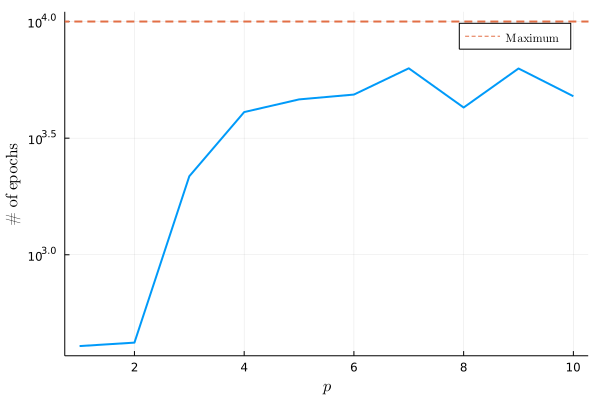

In [14]:
fig = plot(xlabel=L"p",ylabel=L"\textrm{\#\ of\ epochs}")
fig = plot!(Mp,width=2,yscale=:log10,label=false)
fig = hline!([M],width=2,style=:dash,label=L"\textrm{Maximum}")

How should we choose the final parameter set that defines our guess of $f$?

- You may be tempted to choose the minimizer of the *training* MSE; it *is* the error from the largest dataset. However, we should stay mindful that it is suceptible to overfitting.
- How about the *test* MSE? Recall that we are, for all intents and purposes, pretending that the test set doesn't exist for the entire model selection process. In many cases (e.g., data challenges) we wouldn't even be able to calculate the test MSE!

That leaves us with using the *CV* MSE. Since we have $K$ MSEs for each $p$, there are many ways to choose the final parameter set, but we will use the following rule:

$$
\hat\theta := \hat\theta_{p^\ast}\text{ s.t. }p^\ast = \arg\min_p\frac{1}{K}\sum_{k=1}^K\text{MSE}_p^{(k)},
$$

meaning that we first decide $p$ based on the lowest *averaged* CV MSE, then retrain with the entire train set using the "best" $p$ to arrive at the final estimate $\hat f:=\mathcal{N}_{\hat\theta}$.

Let's plot out the results from our training algorithm:

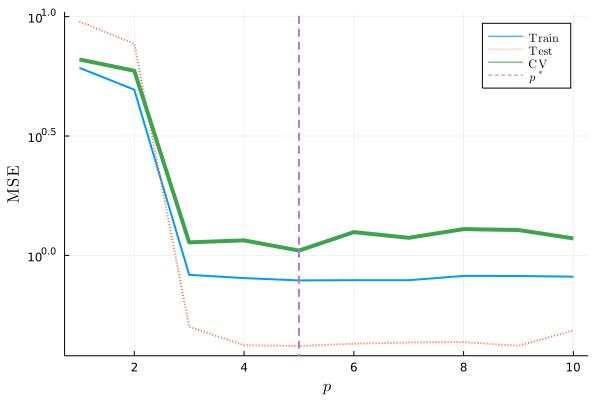

In [15]:
popt = argmin(mean.(MSEcv))
θ̂ = θp[popt]

fig = plot(xlabel=L"p",ylabel=L"\textrm{MSE}",yscale=:log10)
fig = plot!(MSEtr,width=2,label=L"\textrm{Train}")
fig = plot!(MSEts,width=2,style=:dot,label=L"\textrm{Test}")
fig = plot!(mean.(MSEcv),width=4,label=L"\textrm{CV}")
fig = vline!([popt],width=2,style=:dash,label=L"p^*")

Given our decision rule for model selection, we find that our "optimal" basis functions are monomials of degree at most 5, after which the CV error starts increasing.

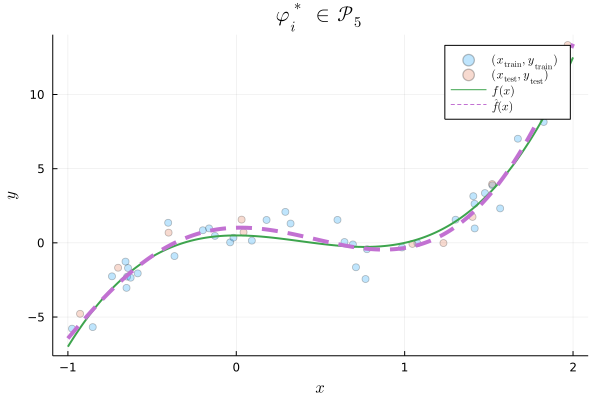

In [16]:
fig = plot(xlabel=L"x",ylabel=L"y",title=L"\varphi^*_i\in\mathcal{P}_{%$popt}")
fig = scatter!(x,y,markeralpha=0.25,label=L"(x_\mathrm{train},y_\mathrm{train})")
fig = scatter!(x_test,y_test,markeralpha=0.25,label=L"(x_\mathrm{test},y_\mathrm{test})")
fig = plot!(X,𝒫.(X,Ref(θ̄)),width=2,label=L"f(x)")
fig = plot!(X,𝒫.(X,Ref(θ̂)),width=4,style=:dash,label=L"\hat f(x)")

As a comparison, we will plot an alternate solution $\mathcal{N}_{\hat\theta_{10}}(x)$.

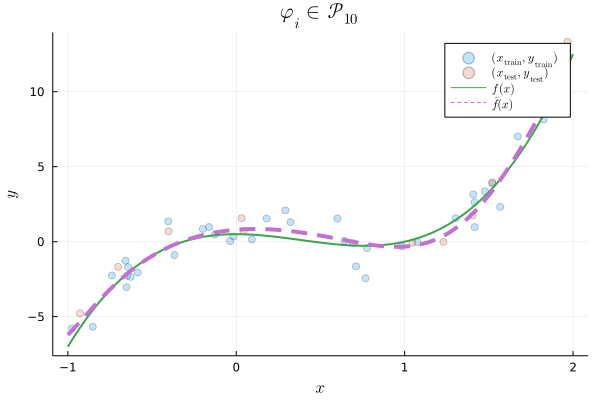

In [17]:
fig = plot(xlabel=L"x",ylabel=L"y",title=L"\varphi_i\in\mathcal{P}_{%$P}")
fig = scatter!(x,y,markeralpha=0.25,label=L"(x_\mathrm{train},y_\mathrm{train})")
fig = scatter!(x_test,y_test,markeralpha=0.25,label=L"(x_\mathrm{test},y_\mathrm{test})")
fig = plot!(X,𝒫.(X,Ref(θ̄)),width=2,label=L"f(x)")
fig = plot!(X,𝒫.(X,Ref(θp[P])),width=4,style=:dash,label=L"\hat f(x)")

The "overfitting" that we expect in this case is barely noticeable, if at all (this might have to do with our choice of optimizer and related-parameters).

## Check with linear regression

If you are thinking that this was a terrible way to solve the regression problem, you are right. And we stress again that the above method of using NNs was solely to set up a recipe for actual DL problems, and I hope it was somewhat instructive. For completeness, let's solve the problem using the usual SVD/pseudoinverse method...

In [18]:
MSEcv = [zeros(K) for p ∈ 1:P]
MSEtr = zeros(P)
MSEts = zeros(P)
θcv = Array{Any}(undef,P)
θp = Array{Any}(undef,P)

pm = Progress(P)
for p ∈ 1:P
    # Compute features (monomials)
    Φ = vcat((i->ϕ.(x,i)).(0:p)'...)
    Φ_test = vcat((i->ϕ.(x_test,i)).(0:p)'...)

    # Run cross-validation
    θk = Array{Any}(undef,K)
    for k ∈ 1:K
        # Split train/valid
        ℐt,ℐv = vcat(ℐ[setdiff(1:K,k)]...),ℐ[k]

        # CV train/solve y = Φᵀθ
        θ = Φ[:,ℐt]'\y[ℐt]
        θk[k] = [θ[2:end]',θ[1]]

        # CV test error
        MSEcv[p][k] = ℒ(x->θ'*x,Φ[:,ℐv],y[ℐv]')
    end
    θcv[p] = θk

    # Train/solve y = Φᵀθ
    θ = Φ'\y
    θp[p] = [θ[2:end]',θ[1]]

    # Train error
    MSEtr[p] = ℒ(x->θ'*x,Φ,y')

    # Test error
    MSEts[p] = ℒ(x->θ'*x,Φ_test,y_test')
    next!(pm)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


... and plot the same figures as above:

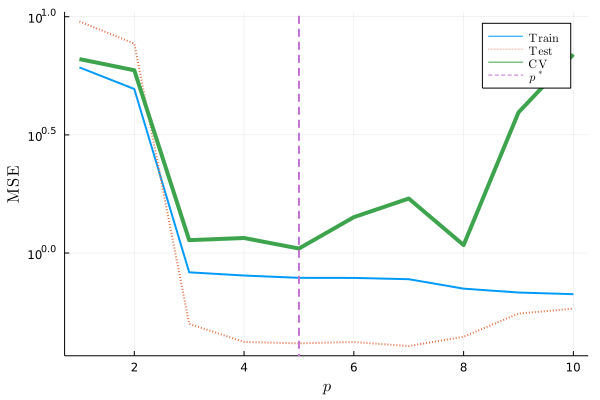

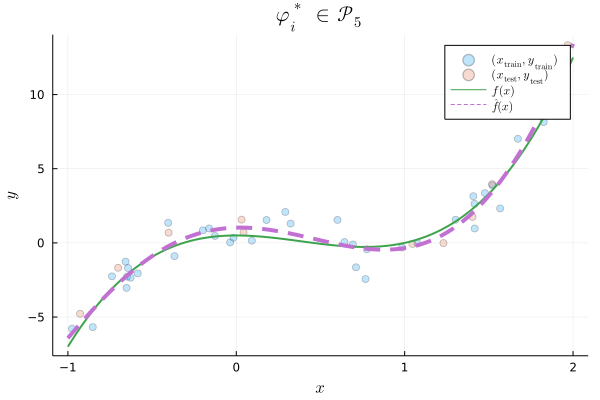

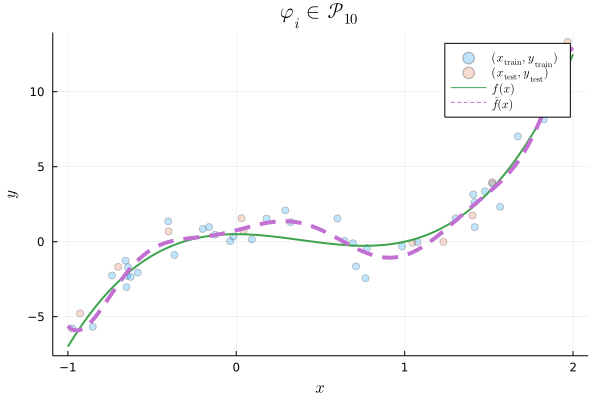

In [19]:
popt = argmin(mean.(MSEcv))
θ̂ = θp[popt]

fig = plot(xlabel=L"p",ylabel=L"\textrm{MSE}",yscale=:log10)
fig = plot!(MSEtr,width=2,label=L"\textrm{Train}")
fig = plot!(MSEts,width=2,style=:dot,label=L"\textrm{Test}")
fig = plot!(mean.(MSEcv),width=4,label=L"\textrm{CV}")
fig = vline!([popt],width=2,style=:dash,label=L"p^*")
display(fig)

fig = plot(xlabel=L"x",ylabel=L"y",title=L"\varphi^*_i\in\mathcal{P}_{%$popt}")
fig = scatter!(x,y,markeralpha=0.25,label=L"(x_\mathrm{train},y_\mathrm{train})")
fig = scatter!(x_test,y_test,markeralpha=0.25,label=L"(x_\mathrm{test},y_\mathrm{test})")
fig = plot!(X,𝒫.(X,Ref(θ̄)),width=2,label=L"f(x)")
fig = plot!(X,𝒫.(X,Ref(θ̂)),width=4,style=:dash,label=L"\hat f(x)")
display(fig)

fig = plot(xlabel=L"x",ylabel=L"y",title=L"\varphi_i\in\mathcal{P}_{%$P}")
fig = scatter!(x,y,markeralpha=0.25,label=L"(x_\mathrm{train},y_\mathrm{train})")
fig = scatter!(x_test,y_test,markeralpha=0.25,label=L"(x_\mathrm{test},y_\mathrm{test})")
fig = plot!(X,𝒫.(X,Ref(θ̄)),width=2,label=L"f(x)")
fig = plot!(X,𝒫.(X,Ref(θp[P])),width=4,style=:dash,label=L"\hat f(x)")

Note how the increase in CV errors is much more significant, leading to the clear overfitting to the training data in the final plot.